# NAVER 영화평 분류 모델 생성

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
train_df = pd.read_csv('../static/data/naver/ratings_train.txt', sep='\t')
test_df = pd.read_csv('../static/data/naver/ratings_test.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [3]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

### 데이터 전처리

- train data

In [4]:
# 중복 샘플 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146183, 3)

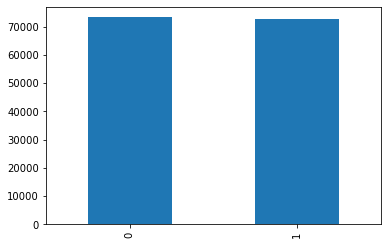

In [5]:
# 긍정, 부정 레이블 값의 분포
train_df.label.value_counts().plot(kind='bar');

In [6]:
# 0: 긍정 / 1: 부정
train_df.label.value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [7]:
# Null 값 확인
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [8]:
train_df.loc[train_df.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [9]:
train_df = train_df.dropna(how='any')
train_df.shape

(146182, 3)

In [10]:
# 'id' 열 제거
train_df.drop('id', axis=1, inplace=True)

In [11]:
train_df.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- test data

In [12]:
test_df['document'].nunique()

49157

In [13]:
# 중복 샘플 제거
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49158, 3)

In [14]:
# Null 제거
test_df = test_df.dropna(how='any')
test_df.shape

(49157, 3)

In [15]:
# 'id' 열 제거
test_df.drop('id', axis=1, inplace=True)

In [16]:
test_df.head()

,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 텍스트 전처리

- train data

In [17]:
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head()

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [18]:
train_df['document'].replace('', np.nan, inplace=True)
train_df.isnull().sum()

document    391
label         0
dtype: int64

In [19]:
train_df = train_df.dropna(how='any')
print(f'전처리 후 테스트용 샘플의 개수: {len(train_df)}')

전처리 후 테스트용 샘플의 개수: 145791


- test data

In [20]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df.isnull().sum()

document    162
label         0
dtype: int64

In [21]:
test_df = test_df.dropna(how='any')
print(f'전처리 후 테스트용 샘플의 개수: {len(test_df)}')

전처리 후 테스트용 샘플의 개수: 48995


In [22]:
train_df.to_csv('../static/data/naver/train.tsv', sep='\t', index=False)
test_df.to_csv('../static/data/naver/test.tsv', sep='\t', index=False)

### 토큰화

In [23]:
new_train = pd.read_csv('../static/data/naver/train.tsv', sep='\t')
new_test = pd.read_csv('../static/data/naver/test.tsv', sep='\t')

In [24]:
new_train.head(3)

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0


In [25]:
from konlpy.tag import Okt

okt = Okt()

In [26]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [27]:
from tqdm import tqdm_notebook
X_train = []
for sentence in tqdm_notebook(new_train['document']):
    morphs = okt.morphs(sentence, stem=True)    # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords])     # 불용어 제거
    X_train.append(temp_X)

<ipython-input-27-63fe65e1ba5a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(new_train['document']):


In [28]:
X_train[0]

'아 더빙 진짜 짜증나다 목소리'

In [29]:
X_test = []
for sentence in tqdm_notebook(new_test['document']):
    morphs = okt.morphs(sentence, stem=True)    # 토큰화
    temp_X = ' '.join([word for word in morphs if not word in stopwords])     # 불용어 제거
    X_test.append(temp_X)

<ipython-input-29-6e2c65e359f0>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(new_test['document']):


In [30]:
X_test[1]

'뭐 야 평점 나쁘다 않다 점 짜다 리 더 더욱 아니다'

In [31]:
y_train = new_train.label.values
y_test = new_test.label.values

### 학습/예측/평가

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import joblib

#### 1) CountVectorizer + LogisticRegression

In [33]:
pipeline = Pipeline([
    ('count_vect', CountVectorizer(ngram_range=(1, 2))),
    ('lr_clf', LogisticRegression())
])
params = ({
    #'count_vect__max_df': [100, 300, 500],
    'count_vect__max_df': [400, 500, 600],
    #'lr_clf__C': [1, 5, 10]
    'lr_clf__C': [0.1, 1, 3]
})

In [34]:
count_lr = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
count_lr.fit(X_train, y_train)
print(f'최고 평균 정확도: {count_lr.best_score_:.4f}')
print('최적 파라미터:', count_lr.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  7.2min finished
최고 평균 정확도: 0.8150
최적 파라미터: {'count_vect__max_df': 600, 'lr_clf__C': 1}
C:\Users\samsung\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
best_count_lr = count_lr.best_estimator_
pred_count_lr = best_count_lr.predict(X_test)
acc = accuracy_score(y_test, pred_count_lr)
print(f'CountVectorizer + LogisticRegression 정확도: {acc:.4f}')

CountVectorizer + LogisticRegression 정확도: 0.8158


In [36]:
joblib.dump(best_count_lr, '../static/model/naver_count_lr.pkl')

['../static/model/naver_count_lr.pkl']

#### 2) CountVectorizer + MultinomialNB(나이브베이즈)

In [37]:
pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('nb_clf', MultinomialNB())
])

In [38]:
pipeline.get_params()

{'memory': None,
 'steps': [('count_vect', CountVectorizer()), ('nb_clf', MultinomialNB())],
 'verbose': False,
 'count_vect': CountVectorizer(),
 'nb_clf': MultinomialNB(),
 'count_vect__analyzer': 'word',
 'count_vect__binary': False,
 'count_vect__decode_error': 'strict',
 'count_vect__dtype': numpy.int64,
 'count_vect__encoding': 'utf-8',
 'count_vect__input': 'content',
 'count_vect__lowercase': True,
 'count_vect__max_df': 1.0,
 'count_vect__max_features': None,
 'count_vect__min_df': 1,
 'count_vect__ngram_range': (1, 1),
 'count_vect__preprocessor': None,
 'count_vect__stop_words': None,
 'count_vect__strip_accents': None,
 'count_vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'count_vect__tokenizer': None,
 'count_vect__vocabulary': None,
 'nb_clf__alpha': 1.0,
 'nb_clf__class_prior': None,
 'nb_clf__fit_prior': True}

In [39]:
params = ({
    'count_vect__ngram_range': [(1, 1), (1, 2)],
    'count_vect__max_df': [100, 300, 500]
})

In [40]:
count_nb = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
count_nb.fit(X_train, y_train)
print(f'최고 평균 정확도: {count_nb.best_score_:.4f}')
print('최적 파라미터:', count_nb.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.6s finished
최고 평균 정확도: 0.8236
최적 파라미터: {'count_vect__max_df': 500, 'count_vect__ngram_range': (1, 2)}


In [41]:
best_count_nb = count_nb.best_estimator_
pred_count_nb = best_count_nb.predict(X_test)
acc = accuracy_score(y_test, pred_count_nb)
print(f'CountVectorizer + 나이브베이즈 정확도: {acc:.4f}')

CountVectorizer + 나이브베이즈 정확도: 0.8217


In [42]:
joblib.dump(best_count_nb, '../static/model/naver_count_nb.pkl')

['../static/model/naver_count_nb.pkl']

#### 3) TfidfVectorizer + LogisticRegression

In [43]:
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('lr_clf', LogisticRegression())
])
params = ({
    'tfidf_vect__max_df': [100, 300, 500],
    'lr_clf__C': [1, 5, 10]
})

In [44]:
tfidf_lr = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
tfidf_lr.fit(X_train, y_train)
print(f'최고 평균 정확도: {tfidf_lr.best_score_:.4f}')
print('최적 파라미터:', tfidf_lr.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.5min finished
최고 평균 정확도: 0.8170
최적 파라미터: {'lr_clf__C': 5, 'tfidf_vect__max_df': 500}


In [45]:
best_tfidf_lr = tfidf_lr.best_estimator_
pred_tfidf_lr = best_tfidf_lr.predict(X_test)
acc = accuracy_score(y_test, pred_tfidf_lr)
print(f'TfidfVectorizer + LogisticRegression 정확도: {acc:.4f}')

TfidfVectorizer + LogisticRegression 정확도: 0.8141


In [46]:
joblib.dump(best_tfidf_lr, '../static/model/naver_tfidf_lr.pkl')

['../static/model/naver_tfidf_lr.pkl']

#### 4) TfidfVectorizer + MultinomialNB(나이브베이즈)

In [47]:
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer()),
    ('nb_clf', MultinomialNB())
])

In [48]:
pipeline.get_params()

{'memory': None,
 'steps': [('tfidf_vect', TfidfVectorizer()), ('nb_clf', MultinomialNB())],
 'verbose': False,
 'tfidf_vect': TfidfVectorizer(),
 'nb_clf': MultinomialNB(),
 'tfidf_vect__analyzer': 'word',
 'tfidf_vect__binary': False,
 'tfidf_vect__decode_error': 'strict',
 'tfidf_vect__dtype': numpy.float64,
 'tfidf_vect__encoding': 'utf-8',
 'tfidf_vect__input': 'content',
 'tfidf_vect__lowercase': True,
 'tfidf_vect__max_df': 1.0,
 'tfidf_vect__max_features': None,
 'tfidf_vect__min_df': 1,
 'tfidf_vect__ngram_range': (1, 1),
 'tfidf_vect__norm': 'l2',
 'tfidf_vect__preprocessor': None,
 'tfidf_vect__smooth_idf': True,
 'tfidf_vect__stop_words': None,
 'tfidf_vect__strip_accents': None,
 'tfidf_vect__sublinear_tf': False,
 'tfidf_vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf_vect__tokenizer': None,
 'tfidf_vect__use_idf': True,
 'tfidf_vect__vocabulary': None,
 'nb_clf__alpha': 1.0,
 'nb_clf__class_prior': None,
 'nb_clf__fit_prior': True}

In [49]:
params = ({
    #'tfidf_vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf_vect__ngram_range': [(1, 2)],
    #'tfidf_vect__max_df': [100, 300, 500]
    #'tfidf_vect__max_df': [500, 550, 600, 650, 700]
    'tfidf_vect__max_df': [900, 950, 1000, 1200]
})

In [50]:
tfidf_nb = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
tfidf_nb.fit(X_train, y_train)
print(f'최고 평균 정확도: {tfidf_nb.best_score_:.4f}')
print('최적 파라미터:', tfidf_nb.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   13.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   13.1s finished
최고 평균 정확도: 0.8337
최적 파라미터: {'tfidf_vect__max_df': 1200, 'tfidf_vect__ngram_range': (1, 2)}


In [51]:
best_tfidf_nb = tfidf_nb.best_estimator_
pred_tfidf_nb = best_tfidf_nb.predict(X_test)
acc = accuracy_score(y_test, pred_tfidf_nb)
print(f'TfidfVectorizer + 나이브베이즈 정확도: {acc:.4f}')

TfidfVectorizer + 나이브베이즈 정확도: 0.8340


In [52]:
joblib.dump(best_tfidf_nb, '../static/model/naver_tfidf_nb.pkl')

['../static/model/naver_tfidf_nb.pkl']

### Test

In [53]:
index = 8

In [55]:
df_test = pd.read_csv('../static/data/naver/test.tsv', sep='\t')

In [56]:
df_test.head()

,document,label
0,굳 ㅋ,1
1,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
3,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,음악이 주가 된 최고의 음악영화,1


In [59]:
test_data = []
test_data.append(df_test.iloc[index, 0])
label = '긍정' if df_test.label[index] else '부정'

In [60]:
new_cl = joblib.load('../static/model/naver_count_lr.pkl')
new_cn = joblib.load('../static/model/naver_count_nb.pkl')
new_tl = joblib.load('../static/model/naver_tfidf_lr.pkl')
new_tn = joblib.load('../static/model/naver_tfidf_nb.pkl')

In [61]:
pred_cl = '긍정' if new_cl.predict(test_data)[0] else '부정'
pred_cn = '긍정' if new_cn.predict(test_data)[0] else '부정'
pred_tl = '긍정' if new_tl.predict(test_data)[0] else '부정'
pred_tn = '긍정' if new_tn.predict(test_data)[0] else '부정'

In [62]:
label, pred_cl, pred_cn, pred_tl, pred_tn

('긍정', '긍정', '긍정', '긍정', '긍정')

In [63]:
len(new_test)

48995